In [ ]:
# Get the data
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

--2023-04-29 13:11:56--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘titanic.csv.1’

titanic.csv.1       100%[===================>]  58.89K  --.-KB/s    in 0.003s  

2023-04-29 13:11:56 (21.9 MB/s) - ‘titanic.csv.1’ saved [60302/60302]



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the Titanic dataset
df = pd.read_csv('titanic.csv')

In [ ]:
# Data Exploration -- we can do a lot more than this of course
print(df.head())
print(df.describe())
print(df.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [ ]:
# Data Cleaning
df.drop(columns=['Name', 'Cabin', 'Ticket', 'PassengerId'], inplace=True)
df['Embarked'].fillna('S', inplace=True)
df['Age'].fillna(df['Age'].median(), inplace=True)

In [ ]:
# Feature Engineering
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

In [ ]:
# Imputation
imputer = SimpleImputer(strategy='most_frequent')
df[['Sex', 'Embarked']] = imputer.fit_transform(df[['Sex', 'Embarked']])

<ipython-input-8-09d5d50c8d6b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


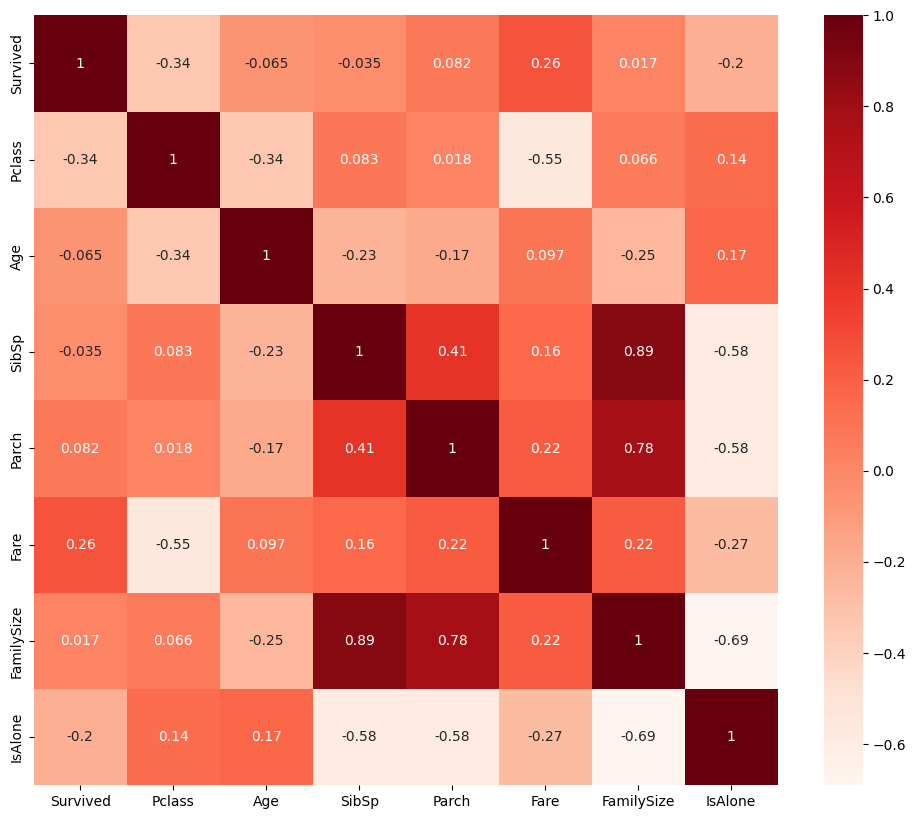

In [ ]:
# Examine correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# Feature Selection -- highly correlated with the FamilySize variable which we engineered
df.drop(columns=['SibSp', 'Parch'], inplace=True)

In [ ]:
df

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,0,3,male,22.0,7.2500,S,2,0
1,1,1,female,38.0,71.2833,C,2,0
2,1,3,female,26.0,7.9250,S,1,1
3,1,1,female,35.0,53.1000,S,2,0
4,0,3,male,35.0,8.0500,S,1,1
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,1,1
887,1,1,female,19.0,30.0000,S,1,1
888,0,3,female,28.0,23.4500,S,4,0
889,1,1,male,26.0,30.0000,C,1,1


In [ ]:
# Convert categorical variables to numerical
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)
df = pd.get_dummies(df, columns=['Embarked'])

In [ ]:
#- Dealing with Imbalanced Classes
X = df.drop(columns=['Survived'])
y = df['Survived']

ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()

X_ros, y_ros = ros.fit_resample(X, y)
X_rus, y_rus = rus.fit_resample(X, y)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [ ]:
# Data Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_lr = GridSearchCV(lr, param_grid, cv=5)
grid_lr.fit(X_train, y_train)

print('Best Parameters for Logistic Regression:', grid_lr.best_params_)

param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_leaf': [2, 5, 10]}
grid_dt = GridSearchCV(dt, param_grid, cv=5)
grid_dt.fit(X_train, y_train)

print('Best Parameters for Decision Tree:', grid_dt.best_params_)

param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7, 10]}
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(X_train, y_train)

print('Best Parameters for Random Forest:', grid_rf.best_params_)

Best Parameters for Logistic Regression: {'C': 1}
Best Parameters for Decision Tree: {'max_depth': 7, 'min_samples_leaf': 10}
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}


In [ ]:
# Final Model
final_model = grid_rf.best_estimator_
final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [ ]:
# Model Evaluation on Test Set
y_pred = final_model.predict(X_test)
print('Final Model Evaluation on Test Set')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Final Model Evaluation on Test Set
Accuracy: 0.8409090909090909
Precision: 0.8727272727272727
Recall: 0.8205128205128205
F1 Score: 0.8458149779735681


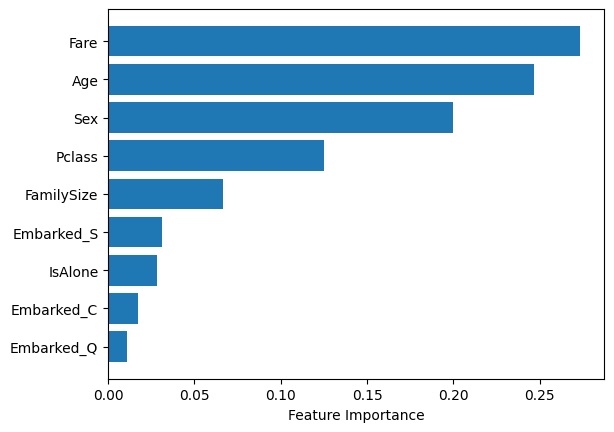

In [ ]:
# Feature Importance
feature_importance = final_model.feature_importances_
feature_names = X.columns
sorted_idx = feature_importance.argsort()

import matplotlib.pyplot as plt
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.show()